In [34]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples


In [35]:
#  Load and normalize ticker data
fund = pd.read_csv('fundamentals.csv')
pri = pd.read_csv('prices.csv')
sec  = pd.read_csv('securities.csv')

fund['Ticker Symbol'] = (
    fund['Ticker Symbol']
    .astype(str)
    .str.strip()
    .str.upper()
)
sec['Ticker symbol'] = (
    sec['Ticker symbol']
    .astype(str)
    .str.strip()
    .str.upper()
)

fund = fund.rename(columns={'For Year':'year', 'Ticker Symbol':'ticker'})
fund = fund.dropna(subset=['year']).copy()
fund['year'] = fund['year'].astype(int)


In [36]:
#  Filter to latest year and select metrics
latest_year = fund['year'].max()
print(f"Using fundamentals for For Year = {latest_year}")

fund_y = fund[fund['year'] == latest_year].copy()
print(f"Tickers available for {latest_year}: {len(fund_y)}")

metrics = [
    'Earnings Per Share',
    'Estimated Shares Outstanding',
    'Total Revenue',
    'Total Equity',
    'Cash Ratio',
    'After Tax ROE'
]
df = fund_y[['ticker'] + metrics].copy()

# Median imputation
for m in metrics:
    df[m] = df[m].fillna(df[m].median())
print("After imputation, missing counts per metric:")
print(df[metrics].isna().sum())


Using fundamentals for For Year = 2016
Tickers available for 2016: 85
After imputation, missing counts per metric:
Earnings Per Share              0
Estimated Shares Outstanding    0
Total Revenue                   0
Total Equity                    0
Cash Ratio                      0
After Tax ROE                   0
dtype: int64


In [37]:
#  (Optional) merge company names
sec = sec.rename(columns={'Ticker symbol':'ticker','Security':'name'})
df = df.merge(sec[['ticker','name']], on='ticker', how='left')


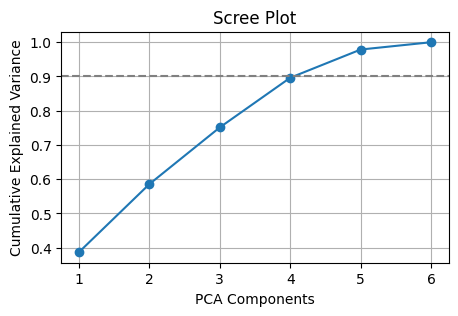

Retaining 5 components → 97.9% variance


In [38]:
#  PCA preprocessing
X = df[metrics].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scree plot for PCA
pca_full = PCA().fit(X_scaled)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(5,3))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.90, linestyle='--', color='gray')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

n_comp = np.searchsorted(cum_var, 0.90) + 1
print(f"Retaining {n_comp} components → {cum_var[n_comp-1]:.1%} variance")

pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)


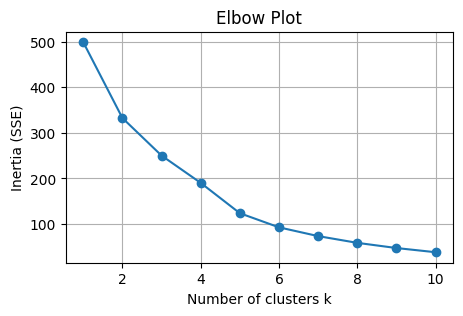

Chosen k = 4


In [39]:
#  Elbow method and K-Means clustering
n_samples = X_pca.shape[0]
max_k = min(10, n_samples)
sse = []
for k in range(1, max_k+1):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    sse.append(km.inertia_)

plt.figure(figsize=(5,3))
plt.plot(range(1, max_k+1), sse, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Plot')
plt.grid(True)
plt.show()

k = min(4, n_samples)
print(f"Chosen k = {k}")
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_pca)


In [40]:
#  Cluster profiling
profile = df.groupby('cluster')[metrics].mean()
print("\nCluster profiles (mean metrics):")
print(profile)

for c in profile.index:
    sample = df[df['cluster']==c]['ticker'].tolist()[:5]
    print(f"Cluster {c} example tickers → {sample}")



Cluster profiles (mean metrics):
         Earnings Per Share  Estimated Shares Outstanding  Total Revenue  \
cluster                                                                    
0                    3.4804                  4.371222e+08   1.994292e+10   
1                    4.2950                  5.411291e+09   2.080840e+11   
2                    2.3960                  3.584812e+08   2.504312e+09   
3                    1.5000                  2.495113e+08   3.038153e+09   

         Total Equity  Cash Ratio  After Tax ROE  
cluster                                           
0        5.977142e+09   71.346667      29.613333  
1        8.609450e+10  138.250000      23.500000  
2        3.041401e+09  566.400000      21.800000  
3        2.310300e+07   96.000000    1620.000000  
Cluster 0 example tickers → ['ABC', 'ADSK', 'AMAT', 'APD', 'AYI']
Cluster 1 example tickers → ['AAPL', 'CSCO', 'MSFT', 'WMT']
Cluster 2 example tickers → ['ADI', 'LLTC', 'MCHP', 'SWKS', 'XLNX']
Cluster 3

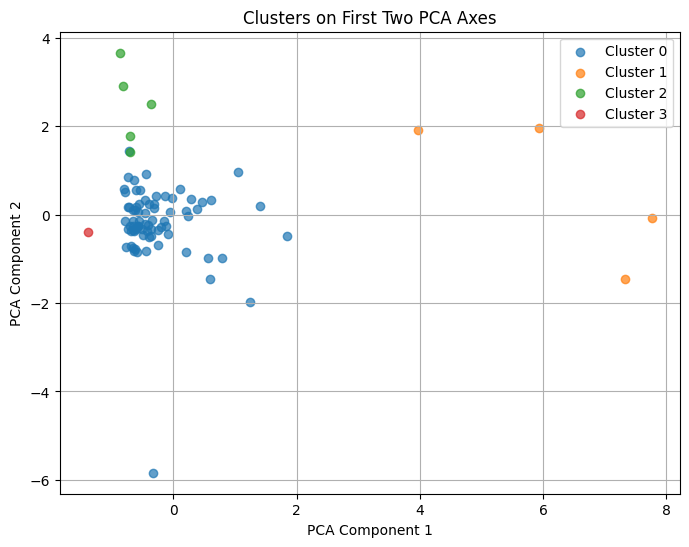

In [41]:
#  2D visualization of clusters on first two PCA components
plt.figure(figsize=(8,6))
for cluster_label in sorted(df['cluster'].unique()):
    mask = (df['cluster'] == cluster_label).values
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                alpha=0.7, label=f'Cluster {cluster_label}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters on First Two PCA Axes')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
#  Silhouette stability across different random seeds
seeds = [0, 10, 42, 100, 200]
print("Silhouette scores for k=4 with different random seeds:")
for seed in seeds:
    km = KMeans(n_clusters=4, random_state=seed, n_init=10).fit(X_pca)
    score = silhouette_score(X_pca, km.labels_)
    print(f"  seed={seed:<3} → silhouette = {score:.4f}")


Silhouette scores for k=4 with different random seeds:
  seed=0   → silhouette = 0.7472
  seed=10  → silhouette = 0.7472
  seed=42  → silhouette = 0.5920
  seed=100 → silhouette = 0.7472
  seed=200 → silhouette = 0.5920


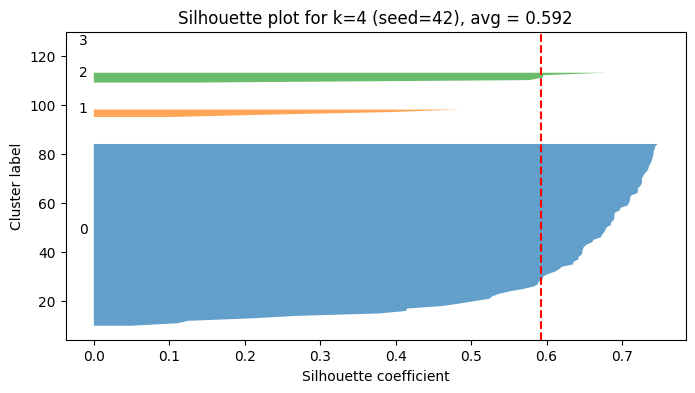

In [43]:
#  Detailed silhouette plot for seed=42 model
km42 = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_pca)
labels = km42.labels_
sil_vals = silhouette_samples(X_pca, labels)

plt.figure(figsize=(8,4))
y_lower = 10
for i in range(4):
    vals = np.sort(sil_vals[labels == i])
    y_upper = y_lower + len(vals)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, vals, alpha=0.7)
    plt.text(-0.02, y_lower + len(vals)/2, str(i))
    y_lower = y_upper + 10

avg_score = silhouette_score(X_pca, labels)
plt.axvline(avg_score, color='red', linestyle='--')
plt.xlabel('Silhouette coefficient')
plt.ylabel('Cluster label')
plt.title(f'Silhouette plot for k=4 (seed=42), avg = {avg_score:.3f}')
plt.show()


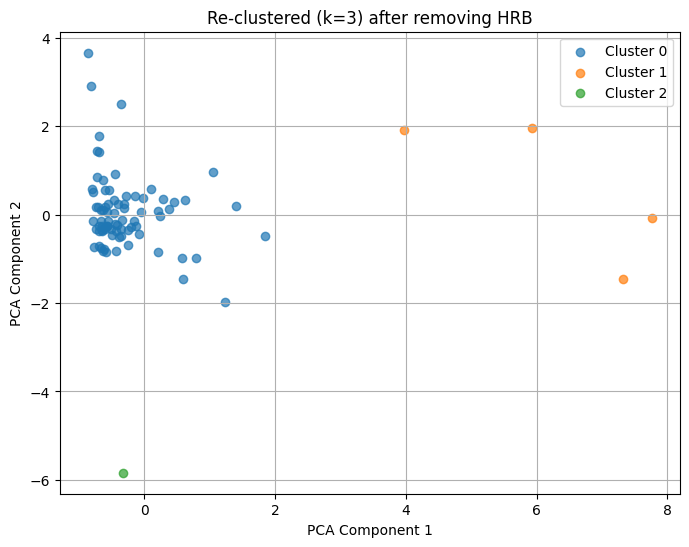

Silhouette score for k=3 (no HRB): 0.7561


In [44]:
#  Remove HRB outlier and re-cluster into k=3
mask_no_hrb = df['ticker'] != 'HRB'
X_pca_no_hrb = X_pca[mask_no_hrb.values]
df_no_hrb = df[mask_no_hrb].copy()

k3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels3 = k3.fit_predict(X_pca_no_hrb)
df_no_hrb['cluster3'] = labels3

# Visualization k=3 without HRB
plt.figure(figsize=(8,6))
for cl in sorted(df_no_hrb['cluster3'].unique()):
    m = (df_no_hrb['cluster3'] == cl).values
    plt.scatter(X_pca_no_hrb[m, 0], X_pca_no_hrb[m, 1],
                alpha=0.7, label=f'Cluster {cl}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Re-clustered (k=3) after removing HRB')
plt.legend()
plt.grid(True)
plt.show()

# Silhouette score for k=3 without HRB
sil3 = silhouette_score(X_pca_no_hrb, labels3)
print(f"Silhouette score for k=3 (no HRB): {sil3:.4f}")


# Why 5 PCA components?
The scree plot showed that the first 5 principal components capture 97.9 % of the total variance, so projecting your 6-dimensional fundamentals onto 5 dimensions loses very little information while simplifying the problem.

# Why k = 4 clusters?
The elbow plot leveled off around k = 4, balancing within-cluster tightness against model complexity.

Beyond k = 4 the drop in SSE (“inertia”) was marginal, so 4 gives you interpretable, well-separated groups.

# 3. Cluster Profiles

| Cluster | EPS      | Shares Outstanding | Revenue    | Equity      | Cash Ratio | After-Tax ROE | Interpretation |
|:-------:|---------:|-------------------:|-----------:|------------:|-----------:|--------------:|:--------------:|
| **0**   | 3.48     | 4.37 × 10⁸         | 1.99 × 10¹⁰| 5.98 × 10⁹  | 71.3       | 29.6 %        | Mid-sized firms with moderate profitability and liquidity. Example tickers: ABC, ADSK, AMAT, APD, AYI. |
| **1**   | 4.30     | 5.41 × 10⁹         | 2.08 × 10¹¹| 8.61 × 10¹⁰| 138.3      | 23.5 %        | Large, cash-rich market-leaders. High revenues and equity base. Example tickers: AAPL, CSCO, MSFT, WMT. |
| **2**   | 2.40     | 3.58 × 10⁸         | 2.50 × 10⁹ | 3.04 × 10⁹  | 566.4      | 21.8 %        | Smaller, highly liquid chip-makers: high cash ratios but lower absolute revenues. Example tickers: ADI, LLTC, MCHP, SWKS, XLNX. |
| **3**   | 1.50     | 2.50 × 10⁸         | 3.04 × 10⁹ | 2.31 × 10⁷  | 96.0       | 1620 %       | **Outlier** (HRB) with tiny equity base and extremely high ROE—likely a one-off anomaly or accounting quirk. |

Cluster 3 contains only HRB, whose tiny equity makes its ROE figure skyrocket. You may choose to treat it as an outlier or investigate its financial footnotes.

# Business Implications
Cluster 1 (tech giants) are established blue-chips—suitable for core holdings or lower-risk mandates.

Cluster 2 (cash-rich chip-manufacturers) could be attractive for short-term liquidity plays or M&A activity.

Cluster 0 (mid-caps) represent moderate growth/profitability—possible balance of upside vs. risk.

Cluster 3 merits further due diligence before any investment decision.

#  Silhouette stability for k=4

seed=0   → 0.7472  
seed=10  → 0.7472  
seed=42  → 0.5920  
seed=100 → 0.7472  
seed=200 → 0.5920  

Three seeds (0, 10, 100) returned a high score of 0.7472, but seeds 42 and 200 fell to 0.5920.

That split tells us k=4 can be unstable depending on initialization: sometimes it finds tight clusters, sometimes much poorer ones.

# Outlier removal & k=3

Silhouette score for k=3 (no HRB): 0.7561
Removing the HRB outlier and re-clustering into 3 groups yields 0.7561, slightly above your best k=4 result (0.7472).

That gain indicates the 3-cluster solution (without the rogue HRB) is more cohesive and stable.

